<a href="https://colab.research.google.com/github/freida20git/SubjectiveQA-Rater/blob/main/notebooks/inference_QArater.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Mount Google Drive
from google.colab import drive

# Core PyTorch and Transformers
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel

# Plotting and numeric tools
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
!pip install transformers

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
metric_cols = [
    'question_asker_intent_understanding', 'question_body_critical', 'question_conversational',
    'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer',
    'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent',
    'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice',
    'question_type_compare', 'question_type_consequence', 'question_type_definition',
    'question_type_entity', 'question_type_instructions', 'question_type_procedure',
    'question_type_reason_explanation', 'question_type_spelling', 'question_well_written',
    'answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance',
    'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure',
    'answer_type_reason_explanation', 'answer_well_written'
]

metric_names = metric_cols


In [6]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
# --- Core libraries ---
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import numpy as np

# --- Device setup (required before loading model) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Define model class (same as used for training) ---
class SiameseBERTRegressor(nn.Module):
    def __init__(self, model_name="bert-base-uncased", hidden_size=768, out_dim=30):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.head = nn.Sequential(
            nn.Linear(2 * hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, out_dim)
        )

    def forward(self, q_input_ids, q_attention_mask, a_input_ids, a_attention_mask):
        q_embed = self.bert(input_ids=q_input_ids, attention_mask=q_attention_mask).pooler_output
        a_embed = self.bert(input_ids=a_input_ids, attention_mask=a_attention_mask).pooler_output
        combined = torch.cat([q_embed, a_embed], dim=1)
        return self.head(combined)


In [8]:
# Load model from Drive
model_path = "/content/drive/MyDrive/QArater/siamese_bert_5e.pt"

model = SiameseBERTRegressor()
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()


SiameseBERTRegressor(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

In [9]:
def predict(model, question_title, question_body, answer):
    model.eval()
    with torch.no_grad():
        q_text = "Title: " + question_title + " [SEP] " + question_body
        a_text = answer

        q_tokens = tokenizer(q_text, return_tensors="pt", truncation=True, padding="max_length", max_length=256)
        a_tokens = tokenizer(a_text, return_tensors="pt", truncation=True, padding="max_length", max_length=256)

        q_ids = q_tokens["input_ids"].to(device)
        q_mask = q_tokens["attention_mask"].to(device)
        a_ids = a_tokens["input_ids"].to(device)
        a_mask = a_tokens["attention_mask"].to(device)

        pred = model(q_ids, q_mask, a_ids, a_mask)
        return pred.squeeze(0).cpu().numpy()  # shape: (30,)


In [13]:
metric_names = metric_cols  # same order as your label columns

# A good QA pair
qa_good = {
    "question_title": "What is the difference between supervised and unsupervised learning?",
    "question_body": "I'm new to machine learning and would like to understand the core difference.",
    "answer": "Supervised learning uses labeled data to train models, while unsupervised learning finds patterns in unlabeled data."
}
qa_bad = {
    "question_title": "apple",
    "question_body": "syntax",
     "answer": "chocolate"
}

In [14]:
pred_good = predict(model, **qa_good)
pred_bad = predict(model, **qa_bad)

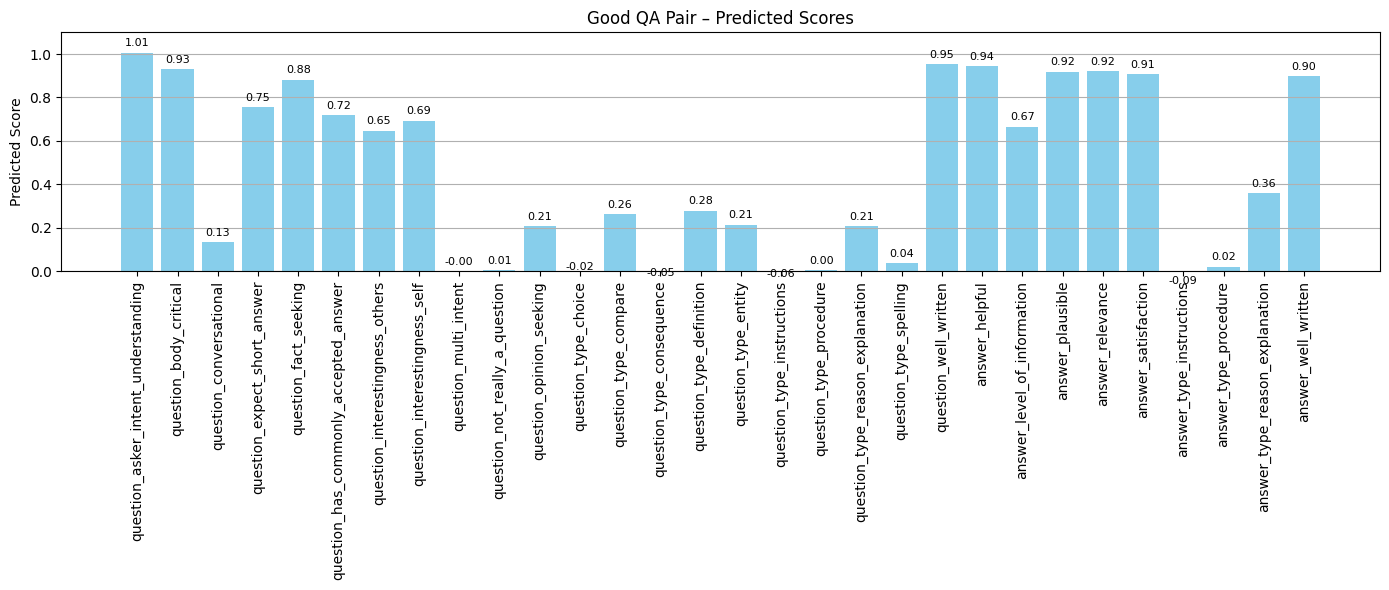

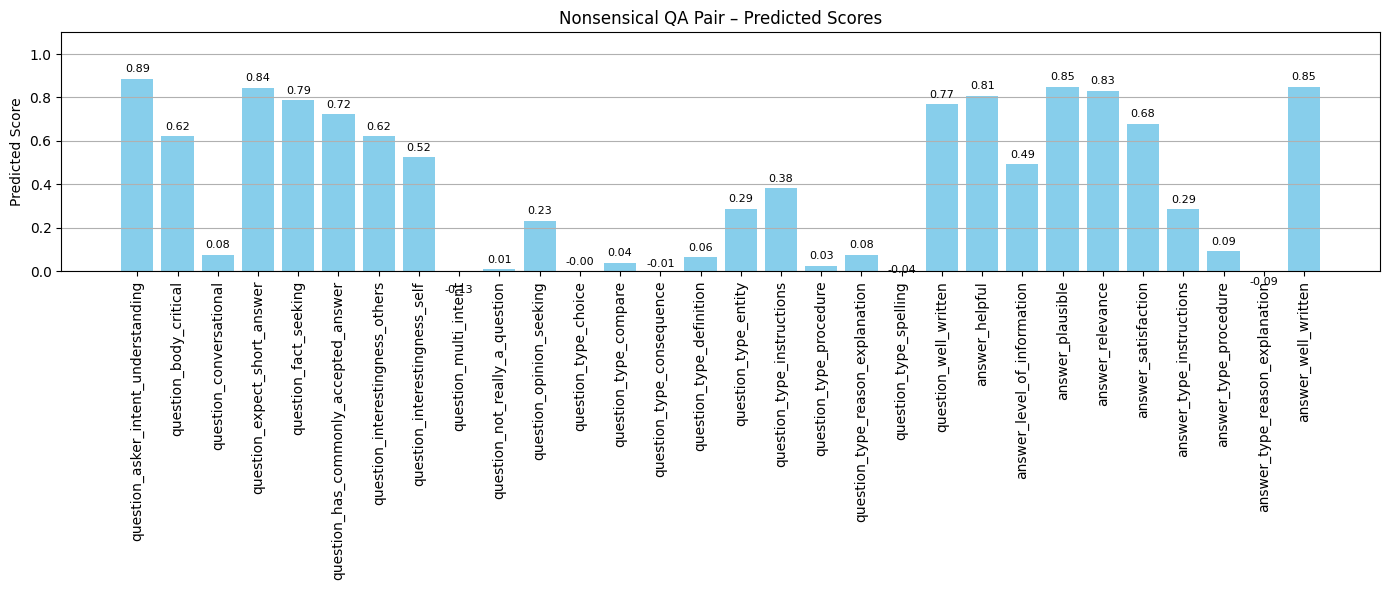

In [15]:
def plot_predictions(preds, title):
    plt.figure(figsize=(14, 6))  # Taller plot (was 14x4)
    bars = plt.bar(metric_names, preds, color='skyblue')
    plt.xticks(rotation=90)
    plt.ylim(0, 1.1)  # Allow space above bars for text
    plt.ylabel("Predicted Score")
    plt.title(title)
    plt.grid(True, axis='y')

    # Add value labels on top of bars
    for bar, score in zip(bars, preds):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{score:.2f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

plot_predictions(pred_good, "Good QA Pair – Predicted Scores")
plot_predictions(pred_bad, "Nonsensical QA Pair – Predicted Scores")
